In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C

import quantstats as qs

In [ ]:
import pandas as pd
df=pd.read_csv("traindf.csv")

In [3]:
# Chuyển cột 'datadate' sang dạng datetime và định dạng lại nó
df['datadate'] = pd.to_datetime(df['datadate'], format='%Y%m%d%H%M%S')

# Đặt cột 'datadate' làm chỉ mục cho DataFrame
df.set_index('datadate', inplace=True)

In [4]:
split_idx = int(0.8 * len(df))
# Split the DataFrame
train_df = df[:split_idx]
test_df = df[split_idx:]

In [5]:
from gym_anytrading.envs import ForexEnv
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'adjcp'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['adjcp', 'high', 'low','volume','turbulence','rsi']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data


window_size = 10
start_index = window_size
end_index = len(train_df)

env = MyForexEnv(df=train_df, window_size=window_size, frame_bound=(start_index, end_index))

In [6]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1000)

In [13]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

KeyboardInterrupt: 

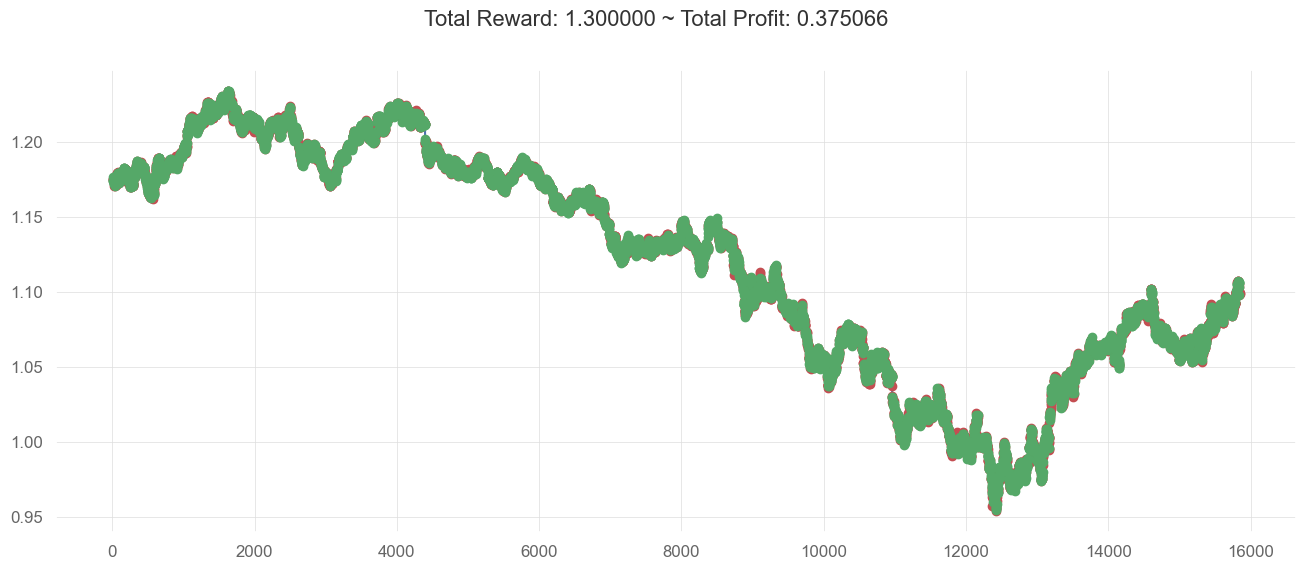

In [8]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [9]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 9378, <Actions.Buy: 1>: 6457}
info: {'total_reward': -1373.800000000273, 'total_profit': 0.3502237038421067, 'position': <Positions.Long: 1>}


In [10]:
from vungo.reports import full
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

metrics= full(returns, tic_name="EURH1", model_name="TD3")
# qs.reports.html(returns, output='SB3_a2c_quantstats.html')

In [11]:
metrics